In [1]:
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

2022-03-09 15:34:28.120230: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


In [2]:
# 定义模型
class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = Conv2D(filters=32, kernel_size=3, activation='relu')
        self.flatten = Flatten()
        self.d1 = Dense(128, activation='relu')
        self.d2 = Dense(10, activation='softmax')
    
    def call(self, x): # [batch, 28, 28, 1]
        x = self.conv1(x) # [batch, 26, 26, 32]
        x = self.flatten(x) # [batch, 26*26*32]
        x = self.d1(x) # [batch, 128]
        x = self.d2(x) # [batch, 10]
        return x

In [14]:
# 加载数据集
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data(
    path=r'/media/hzau/cee8e857-7d9f-4e4c-87f3-e0914d604e8d/LiJiuLiang/001-JN_TensorFlow_env/Untitled Folder/dataset/mnist.npz')

x_train, x_test = x_train / 255.0, x_test / 255.0 # 归一化：将每张图像中的每个像素值转换为0.0 – 1.0之间的浮点数

[7 2 1]


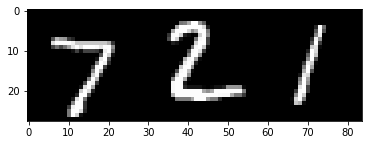

In [4]:
imgs = x_test[:3]
labs = y_test[:3]
print(labs)
plt.imshow(np.hstack(imgs), cmap='gray')

In [5]:
# 将输入数据的维度与tensorflow中tensor要求的输入维度进行匹配
"""
由于tensorflow中tensor的通道排序为[batch, height, width, channel]，
而mnist数据集是灰度图像（通道排序为[batch, height, width]）
所以需要为其增加一个维度，以此符合tensorflow中tensor的通道格式
"""
print(f"before shape : {x_train.shape} ")

x_train = tf.expand_dims(x_train, -1) #-1表示最后一维
x_test = tf.expand_dims(x_test, -1) #-1表示最后一维

# 也可通过：x_train = xtrain[..., tf.newaxis]实现相同效果
print(f"after shape : {x_train.shape} ")


before shape : (60000, 28, 28) 


2022-03-09 15:34:29.947779: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-03-09 15:34:31.104304: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-09 15:34:31.104856: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-03-09 15:34:31.104895: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-09 15:34:31.105329: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 1 with properties: 
pciBusID

after shape : (60000, 28, 28, 1) 


In [6]:
# 搭建数据生成器data generator

"""
1.data.Dataset.from_tensor_slices: 把给定的元组、列表和张量等数据进行特征切片
2.shuffle(1000).batch(32) :先将10000张图片读入内存并随机打乱，然后随机采样32张图片
"""
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(1000).batch(32) 
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32) 

In [7]:
# 实例化模型
model = MyModel()

In [8]:
# 定义损失函数
# SparseCategoricalCrossentropy讲解 :http://www.360doc.com/content/22/0109/12/32196507_1012511560.shtml
loss_object = tf.keras.losses.SparseCategoricalCrossentropy() 

# 定义优化器
optimizer = tf.keras.optimizers.Adam()

In [9]:
# 定义训练过程每一轮loss和accuracy的计算方法
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

# 定义测试过程每一轮loss和accuracy的计算方法
test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [10]:
"""
@tf.function装饰器（构造高效的python代码）
将python代码转为tensorflow的图结构，能够在GPU、TPU上运算
详解：https://www.bilibili.com/read/cv12856573
"""

# 定义训练函数
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images)
        loss = loss_object(labels, predictions)
    gradient = tape.gradient(loss, model.trainable_variables)#将loss反向传播到模型中每一个可训练参数中
    optimizer.apply_gradients(zip(gradient, model.trainable_variables)) #根据梯度更新可训练参数的值
    
    train_loss(loss) # 计算该epoch的loss
    train_accuracy(labels, predictions) #计算该epoch的准确率

# 定义测试函数(注：测试过程不需要进行反向传播)
@tf.function
def test_step(images, labels):
    predictions = model(images)
    loss = loss_object(labels, predictions)
    
    test_loss(loss) # 计算该epoch的loss
    test_accuracy(labels, predictions) #计算该epoch的准确率

In [13]:
epochs = 5

for epoch in range(epochs):
    # 清零
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
    
    for images, labels in train_ds:
        train_step(images, labels)
    
    for images, labels in test_ds:
        test_step(images, labels)
    
    template = "Epoch:{}\nTrain Loss:{}, Train Accuracy:{}%\nTest Loss:{}, Test Accuracy:{}%.\n*****************"
    print(template.format(
        epoch + 1,
        train_loss.result(),
        train_accuracy.result() * 100,
        test_loss.result(),
        test_accuracy.result() * 100
    ))

Epoch:1
Train Loss:0.003962575923651457, Train Accuracy:99.88333892822266%
Test Loss:0.08153823763132095, Test Accuracy:98.5%.
*****************
Epoch:2
Train Loss:0.0030610612593591213, Train Accuracy:99.9000015258789%
Test Loss:0.09736378490924835, Test Accuracy:98.30999755859375%.
*****************
Epoch:3
Train Loss:0.0027011826168745756, Train Accuracy:99.91000366210938%
Test Loss:0.11123457551002502, Test Accuracy:98.30999755859375%.
*****************
Epoch:4
Train Loss:0.0031161783263087273, Train Accuracy:99.89833068847656%
Test Loss:0.12009736895561218, Test Accuracy:98.1500015258789%.
*****************
Epoch:5
Train Loss:0.003336116438731551, Train Accuracy:99.88500213623047%
Test Loss:0.098333440721035, Test Accuracy:98.43000030517578%.
*****************
